In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


import tqdm
from skimage.transform import resize,rotate
from skimage.color import rgb2gray

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.losses import *

from sklearn.model_selection import train_test_split,StratifiedKFold
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
n_pixels = 101
channels = 1
path_train = '../input/train/'
path_test = '../input/test/'

In [3]:
train=pd.read_csv("../input/train.csv")
print(train.shape)
train.head()

(4000, 2)


,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [4]:
sample=pd.read_csv("../input/sample_submission.csv")
print(sample.shape)
sample.head()

(18000, 2)


,id,rle_mask
0,155410d6fa,1 1
1,78b32781d1,1 1
2,63db2a476a,1 1
3,17bfcdb967,1 1
4,7ea0fd3c88,1 1


In [5]:
depth=pd.read_csv("../input/depths.csv")
print(depth.shape)
depth.head()

(22000, 2)


,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [6]:
train_ids = train.id.values
test_ids = sample.id.values

In [7]:
resize_mode='constant'

# Get and resize train images and masks
X = np.zeros((len(train_ids), n_pixels, n_pixels, channels), dtype=np.uint8)
y = np.zeros((len(train_ids), n_pixels, n_pixels, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
for n, id_ in tqdm.tqdm_notebook(enumerate(train_ids),total=len(train_ids)):
    path = path_train
    x = np.array(load_img(path + '/images/' + id_+".png",color_mode='grayscale'))
    X[n] = x.reshape(n_pixels,n_pixels,channels)
    mask = np.array(load_img(path + '/masks/' + id_+".png",color_mode='grayscale'))
    y[n] = mask.reshape(n_pixels,n_pixels,1)

print('Done!')

Getting and resizing train images and masks ... 



Done!


## TEST DATA

In [8]:
# Get and resize test images
X_test = np.zeros((len(test_ids),n_pixels,n_pixels,channels), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
for n, id_ in tqdm.tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    x= np.array(load_img(path + '/images/' + id_+".png",color_mode='grayscale'))
    X_test[n] = x.reshape(n_pixels,n_pixels,1)

print('Done!')

Getting and resizing test images ... 



Done!


In [9]:
# storing empty images 


p=np.ones((4000,))
for i in range(4000):
    p[i]=np.sum(X[i,:,:,:])/(128*128)

trainindex=[]
for j,i in enumerate(p):
    if i==0:
        trainindex.append(j)
        
        
print(len(trainindex))
print(trainindex)

80
[37, 57, 90, 121, 136, 143, 211, 218, 262, 270, 314, 506, 550, 638, 738, 995, 1084, 1394, 1436, 1478, 1567, 1609, 1614, 1623, 1629, 1646, 1695, 1698, 1743, 1773, 1834, 1839, 1842, 1894, 1923, 1928, 1938, 1957, 1986, 2008, 2057, 2192, 2293, 2391, 2393, 2454, 2477, 2521, 2677, 2713, 2725, 2771, 2785, 2799, 2838, 2852, 2882, 2939, 2953, 3015, 3036, 3107, 3206, 3233, 3281, 3362, 3426, 3432, 3502, 3533, 3536, 3640, 3647, 3673, 3684, 3736, 3746, 3779, 3966, 3986]


In [10]:
# storing empty images

q=np.ones((18000,))
for i in range(18000):
    q[i]=np.sum(X_test[i,:,:,:])/(128*128)
    
indextest=[]
for j,i in enumerate(q):
    if i==0:
        indextest.append(j)
        
print(len(indextest))
print(indextest)

430
[67, 128, 137, 138, 172, 183, 220, 251, 273, 373, 377, 385, 404, 496, 513, 551, 638, 656, 665, 704, 837, 844, 854, 905, 915, 919, 954, 995, 1119, 1166, 1175, 1217, 1270, 1291, 1309, 1337, 1348, 1470, 1492, 1499, 1537, 1586, 1588, 1596, 1609, 1627, 1648, 1650, 1656, 1771, 1842, 1845, 1855, 1872, 1924, 1925, 2021, 2033, 2139, 2184, 2220, 2265, 2323, 2341, 2432, 2502, 2603, 2727, 2767, 2780, 2854, 2996, 3043, 3079, 3211, 3286, 3384, 3503, 3514, 3552, 3654, 3666, 3668, 3721, 3724, 3761, 3804, 3810, 3906, 3928, 3963, 4008, 4031, 4044, 4055, 4098, 4109, 4121, 4202, 4218, 4271, 4290, 4295, 4297, 4363, 4424, 4526, 4561, 4569, 4599, 4634, 4723, 4725, 4727, 4741, 4755, 4863, 4883, 4889, 4900, 4904, 4990, 5125, 5132, 5189, 5215, 5224, 5291, 5327, 5341, 5385, 5409, 5430, 5512, 5524, 5576, 5702, 5760, 5777, 5920, 6008, 6039, 6098, 6104, 6140, 6155, 6162, 6211, 6238, 6244, 6335, 6367, 6448, 6454, 6479, 6481, 6488, 6534, 6540, 6556, 6663, 6697, 6766, 6805, 6843, 6879, 6893, 6929, 6942, 6973, 7044

## STRATIFICATION

Calculating the salt coverage class

In [11]:
coverage=np.zeros((train_ids.shape[0],))
for i,name in tqdm.tqdm_notebook(enumerate(train_ids),total=train_ids.shape[0]):
    coverage[i]=np.sum(y[i,:,:,0])

train['coverage']=pd.Series(coverage)/y.shape[1]**2

print(train.shape)
train.head()


(4000, 3)


,id,rle_mask,coverage
0,575d24d81d,NaN,0.000000
1,a266a2a9df,5051 5151,0.504950
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,0.993334
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.149201
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.042839


In [12]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train["coverage_class"] = train.coverage.apply(cov_to_class)

print(train.shape)
train.head()

(4000, 4)


,id,rle_mask,coverage,coverage_class
0,575d24d81d,NaN,0.000000,0
1,a266a2a9df,5051 5151,0.504950,6
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,0.993334,10
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.149201,2
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.042839,1


In [13]:
## coverage class numpy array
coverage=train.coverage_class.values
print(coverage.shape)

(4000,)


In [14]:
train.loc[train['coverage']==0].shape

(1562, 4)

## AUGMENTATION

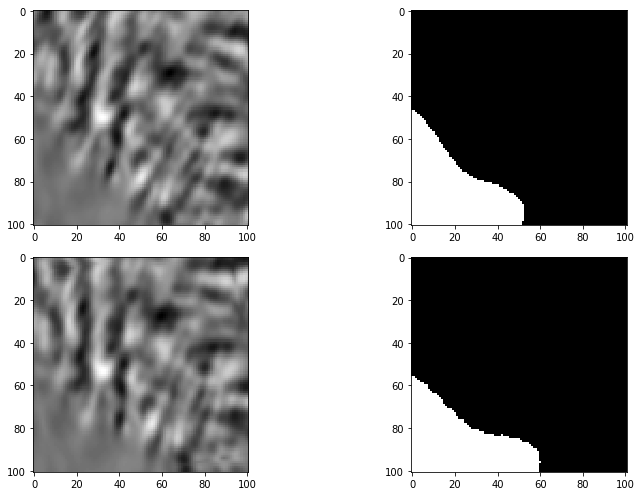

In [15]:
ind=3

p=rotate(X[ind,:,:,0].astype(np.uint8),angle=10,order=1,mode='reflect',
                clip=True,preserve_range=True)
q=rotate(y[ind,:,:,0].astype(np.uint8),angle=10,order=1,mode='reflect',
         clip=True,preserve_range=True)

plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(X[ind].reshape(101,101),cmap='gist_gray')
plt.subplot(222)
plt.imshow(y[ind].reshape(101,101),cmap='gist_gray')
plt.subplot(223)
plt.imshow(p.astype(np.uint8).reshape(101,101),cmap='gist_gray')
plt.subplot(224)
plt.imshow(q.astype(np.uint8).reshape(101,101),cmap='gist_gray')

plt.tight_layout()
plt.show()


In [16]:
def crop_rescale_image(image,mask,state,limit):
    np.random.seed(state)
    h,w=image.shape[0],image.shape[1]
    dy=int(h*limit)
    y0=np.random.randint(int(0.1*h),dy)
    y1=h-y0
    
    
    np.random.seed(state+5000)
    dx=int(w*limit)
    x0=np.random.randint(int(0.1*w),dx)
    x1=w-x0
    
    m='reflect'
#     print(y0,x0)
    cropped_image=resize(image[y0:y1,x0:x1,:],(h,w),mode=m,
                         preserve_range=True)
    cropped_mask=resize(mask[y0:y1,x0:x1,:],(h,w),mode=m,
                        preserve_range=True)

    
    return cropped_image,cropped_mask
    
def random_crop_rescale(X,y,limit):
    m=X.shape[0]
    processed_image=np.zeros(X.shape)
    processed_mask=np.zeros(y.shape)
    for i in range(m):
        processed_image[i,:,:,:],processed_mask[i,:,:,:]=crop_rescale_image(X[i,:,:,:],y[i,:,:,:],i,limit)
    
    return processed_image.astype(np.uint8),processed_mask.astype(np.uint8)


def rotate_grp(images,masks,ang):
    rotated_images=np.zeros((images.shape))
    rotated_masks=np.zeros((masks.shape))
    for i in range(images.shape[0]):
        rotated_images[i,:,:,0]=rotate(X[i,:,:,0].astype(np.uint8),angle=ang,order=1,mode='reflect',
                clip=True,preserve_range=True)
        rotated_masks[i,:,:,0]=rotate(y[i,:,:,0].astype(np.uint8),angle=ang,order=1,mode='reflect',
         clip=True,preserve_range=True)
        
        
    return rotated_images.astype(np.uint8),rotated_masks.astype(np.uint8)

In [17]:
def augment(X,y,l,start_crop,end_crop,start_rot,end_rot,start_roll=-1,end_roll=-1,rolling=False):
    m=X.shape[0]
    print("Flipping")
    X=np.append(X,[np.fliplr(x) for x in X],axis=0)
    y=np.append(y,[np.fliplr(i) for i in y],axis=0)

    # trying random crop and rescale
    np.random.seed(42)
    index=np.arange(0,m)
    # shuffling the array
    np.random.shuffle(index)

    print("Random crop and resize")
    # random crop and resize
    processed_X,processed_y=random_crop_rescale(X[index[start_crop:end_crop]],
                                                y[index[start_crop:end_crop]],limit=l)
    X=np.append(X,processed_X,axis=0)
    y=np.append(y,processed_y,axis=0)

    print("Rotations")
    # 10 degree rotation
    rotated_X,rotated_y=rotate_grp(X[index[start_rot:end_rot]],
                                   y[index[start_rot:end_rot]],ang=10)

    X=np.append(X,rotated_X,axis=0)
    y=np.append(y,rotated_y,axis=0)
    
    if rolling:
        print("Rolling")
        
        roll_index=np.arange(0,X.shape[0])
        
        # shuffling
        np.random.shuffle(roll_index)
        
        # rolling train and mask
        to_roll_X=X[roll_index[start_roll:end_roll]]
        to_roll_y=y[roll_index[start_roll:end_roll]]
            
        # 40 steps rolling
        X=np.append(X,[np.roll(x, 40, axis = 1) for x in to_roll_X], axis = 0)
        y=np.append(y,[np.roll(t,40,axis=1) for t in to_roll_y],axis=0)
        
    return X,y

In [18]:
# metric

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def competition_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)
        
# for lovasz the threshold is zero
def metric_for_lovasz(label,pred):
    return tf.py_func(get_iou_vector,[label,pred>0],tf.float64)


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [19]:
# loss
# here i will add dice and bce loss
# taken from https://www.kaggle.com/kmader/u-net-with-dice-and-augmentation

def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    score=K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
    return 1.0-score

def dice_and_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return binary_crossentropy(in_gt, in_pred) + dice_loss(in_gt, in_pred)

### LOVASZ LOSS

In [20]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

## ARCHITECUTE

In [21]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

def model_call():
    inputs = Input(shape = (n_pixels,n_pixels, channels))

    normalize=True
    batch_normalize=True

    if normalize:
        s=Lambda(lambda x: x / 255) (inputs)
    else:
        s=inputs
    
    DropoutRatio=0.5
    start_neurons=16
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(inputs)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    outputs = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs = [inputs], outputs = [outputs])
    optimizer = Adam()

    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [competition_metric])
#     model.summary()
    
    return model

## INITIALIZATIONS AND FIT DATA FUNCTION

In [22]:
def create_callbacks(name_model,montior_quan,inc_earlystopper=True,inc_checkpointer=True,inc_lr=True,init_lr=True,init_early_stopper=True,
                 init_checkpointer=True,early_stopper=None,check_pointer=None,reduce_lr=None):
    
    callback=[]
    
    if inc_earlystopper:
        earlystopper=None
        # if early stopper is included then 
        if init_early_stopper:
            # to initialize the early stopper
            earlystopper = EarlyStopping(monitor=montior_quan,patience=15,
                             mode='max',verbose=1)
        else:
            # make the early stopper given by user
            if early_stopper!=None:
                earlystopper=early_stopper
            else:
                print("Error Not given early stopper")
    
        callback.append(earlystopper)
        
    if inc_lr:
        reduce_lr=None
        if init_lr:
            reducelr=ReduceLROnPlateau(monitor=montior_quan,patience=5, 
                            min_lr=0.00001,mode='max',verbose=1,factor=0.5)
        else:
            if reduce_lr!=None:
                reducelr=reduce_lr
            else:
                print("Error Not given reduce lr on plateau")
        
        callback.append(reducelr)
        
    if inc_checkpointer:
        checkpointer=None
        if init_checkpointer:
            checkpointer = ModelCheckpoint(name_model, monitor=montior_quan,mode='max',
                               verbose=1, save_best_only=True)
        else:
            if check_pointer!=None:
                checkpointer=check_pointer
            else:
                print("Error not given model checkpointer")
    
        callback.append(checkpointer)
        
    return callback

def fit_data(model,X_train,y_train,X_val,y_val,batches,ep,name_model,verb,monitor_quan,
                inc_earlystopper=True,inc_checkpointer=True,inc_lr=True,init_lr=True,init_early_stopper=True,
                 init_checkpointer=True,early_stopper=None,check_pointer=None,reduce_lr=None):
    
    # callbacks initialization
    callback=create_callbacks(name_model,monitor_quan,inc_earlystopper,inc_checkpointer,inc_lr,init_lr,
                              init_early_stopper,init_checkpointer,early_stopper,check_pointer,reduce_lr)
    
    
    results = model.fit(X_train, y_train, validation_data=[X_val,y_val], 
                        batch_size=batches, epochs=ep, callbacks=callback,verbose=verb)
    
    return results
    
    
def create_model_for_loavsz(model1):
    # remove layter activation layer and use losvasz loss
    input_x = model1.layers[0].input

    output_layer = model1.layers[-1].input
    model = Model(input_x, output_layer)
    c = adam()

    # lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
    # Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[metric_for_lovasz])

#     model.summary()

    return model

In [ ]:
# training
n_folds=5
kfold=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=42)
preds_test=np.zeros((18000,101,101,1))
preds_test_flip=np.zeros((18000,101,101,1))

folds_size=[6208,6206,6200,6188,6184]
 # number
foldnumber=0

preds_valid=np.zeros((folds_size[foldnumber],101,101,1))



for fold,(train_index,val_index) in enumerate(kfold.split(X,coverage)):
    if fold==foldnumber:
        X_train,X_val=X[train_index],X[val_index]
        y_train,y_val=y[train_index],y[val_index]
    
        print("================================= FOLD",fold+1,"=============================================")
    
     
        print(X_train.shape,X_val.shape)
    
        # augmentation
        print("Training Augmentation")
        X_train,y_train=augment(X_train,y_train,l=0.3,start_crop=0,end_crop=1600,
                            start_rot=1600,end_rot=3200,start_roll=0,end_roll=4000,rolling=True)

        print("Validation Augmentation")
        X_val,y_val=augment(X_val,y_val,l=0.3,start_crop=0,end_crop=800,
                        start_rot=0,end_rot=800,start_roll=0,end_roll=3000,rolling=True)
    
    
        print("Data shape")
        print(X_train.shape,X_val.shape)
    
    
        model=model_call()
    
        save_name='models/resnet_unet_kfold_lovasz_public_'+str(fold+1)+'.h5'
    
    
        # first it is binary cross entropy.
    
        batch_size=64
        epochs=80
        verbose=0
    
        monitor_quantity = 'val_competition_metric'
    
        result=fit_data(model,X_train,y_train,X_val,y_val,batch_size,
                    epochs,name_model=save_name,verb=verbose,monitor_quan=monitor_quantity)
    
        print("Done with binary cross entropy")
    
        # fit done and now we have to use lovasz loss
    
        # loading the best model
        model1=load_model(save_name,custom_objects={'competition_metric': competition_metric})
    
        # creating the model for loavsz 
        model=create_model_for_loavsz(model1)
    
        print("Model ready for lovasz training")
    
        batch_size=64
        epochs=80
        verbose=0
    
        monitor_quantity = 'val_metric_for_lovasz'    
    
        result=fit_data(model,X_train,y_train,X_val,y_val,batch_size,
                    epochs,name_model=save_name,verb=verbose,monitor_quan=monitor_quantity)

    
        print("Done with training in this fold")

        # loading the final model
        model = load_model(save_name, custom_objects={'metric_for_lovasz': metric_for_lovasz,
                                                   'lovasz_loss': lovasz_loss})
    

        print(model.metrics_names)
        print(model.evaluate(X_val,y_val))
    
        # making the predicitons on validation data
        preds_valid=preds_valida+model.predict(X_val,verbose=1)
    
        # making test predictions
        preds_test=preds_test+(model.predict(X_test,verbose=1))/n_folds
    
        # tta
        X_test_flip=np.array([np.fliplr(x) for x in X_test])
        flipping_predictions=model.predict(X_test_flip,verbose=1)
    
        # now i have to flip these predictions
        flipping_predictions=np.array([np.fliplr(x) for x in flipping_predictions])
    
        # saving the predictions 
        preds_test_flip=preds_test_flip+flipping_predictions/n_folds
    

In [ ]:
%%time

preds_name="resnet_5_fold_64_batch_loavsz_"+str(foldnumber)
# saving the test predictions
name=preds_name
np.save(name,preds_test)

# saving the flip predictions
name=preds_name+"_tta"
np.save(name,preds_test_flip)

# saving the valid predictions
name=preds_name+"_validation"
np.save(name,preds_valid)